<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/99_wrapup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Summary
---

tba

## Prerequisites
---

### Installation (if needed)

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
IN_COLAB

False

In [2]:
if IN_COLAB:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon

    # pull (the currenct version of the repo)
    !git pull

In [3]:
!python --version
# 3.9.* or 3.10.* work fine.

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Python 3.9.16


In [4]:
if IN_COLAB: 
  !pip install -q tensorflow-federated==0.56.0
  #!pip install -r requirements.txt

In [5]:
!pip list | grep tensorflow
# for more details use !pip show tensorflow
#>tensorflow                    2.12.0
#>tensorflow-compression        2.12.0
#>tensorflow-datasets           4.8.3
#>tensorflow-estimator          2.12.0
#>tensorflow-federated          0.56.0
#>tensorflow-gcs-config         2.12.0
#>tensorflow-hub                0.13.0
#>tensorflow-io-gcs-filesystem  0.32.0
#>tensorflow-metadata           1.13.1
#>tensorflow-model-optimization 0.7.3
#>tensorflow-privacy            0.8.8
#>tensorflow-probability        0.15.0

/bin/bash: /home/olihauke/.asdf/installs/python/miniconda3-latest/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
tensorflow                    2.12.0
tensorflow-compression        2.12.0
tensorflow-datasets           4.9.2
tensorflow-estimator          2.12.0
tensorflow-federated          0.56.0
tensorflow-io-gcs-filesystem  0.32.0
tensorflow-metadata           1.13.1
tensorflow-model-optimization 0.7.3
tensorflow-privacy            0.8.8
tensorflow-probability        0.15.0


In [6]:
# Save the package versioning to requirements.txt if needed (ovewrites the previous)
#!conda list --export > ../requirements.txt
# or
#!pip freeze > ../requirements.txt

### Imports
---

In [1]:
import pandas as pd
import numpy as np
import os
import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from itertools import product
from math import floor
import time

import tensorflow as tf
import tensorflow_federated as tff
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.callbacks import CSVLogger

# -> check tff
#print(tff.federated_computation(lambda: 'Hello World')()) 

2023-05-05 08:41:22.143781: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 08:41:24.537284: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Ingest data
---

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/Olhaau/fl-official-statistics-addon/main/output/data/insurance-clean.csv", index_col = 0)
df.head()

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.55230,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.46200,0.0,0.0,1.0,0.0
3,0.326087,1.0,0.181464,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,0.0
4,0.304348,1.0,0.347592,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,0.0


##### Select feature and target

In [5]:
features = ['age', 'sex', 'bmi', 'children', 'smoker'
            , 'region0', 'region1', 'region2', 'region3']
target = 'charges'

##### Evaluation splits

In [6]:
nfolds = 5
nreps = 5

cv = RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nreps, random_state = 42)

ind = 0
for train, test in cv.split(df, df.region):
  
  label = 'rep' + str(floor(ind / nfolds)) + '-fold' + str(ind % nfolds)
  df.loc[train, label] = 'train'
  df.loc[test,  label] = 'test'
  ind += 1

df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'region0', 'region1', 'region2', 'region3', 'rep0-fold0', 'rep0-fold1',
       'rep0-fold2', 'rep0-fold3', 'rep0-fold4', 'rep1-fold0', 'rep1-fold1',
       'rep1-fold2', 'rep1-fold3', 'rep1-fold4', 'rep2-fold0', 'rep2-fold1',
       'rep2-fold2', 'rep2-fold3', 'rep2-fold4', 'rep3-fold0', 'rep3-fold1',
       'rep3-fold2', 'rep3-fold3', 'rep3-fold4', 'rep4-fold0', 'rep4-fold1',
       'rep4-fold2', 'rep4-fold3', 'rep4-fold4'],
      dtype='object')

In [8]:
def select_split(
      df, 
      target = target, 
      features = features, 
      type = 'train', 
      rep = 0, 
      fold = 0
      ):
   """selects the train and test set from a specific column.

  Parameters
  ------------
  df: dataFrame
  target: str
  features: list of str
  type: str
      'train' or 'test'.
  rep, fold: int
      Considered is a repeated cross validation with ``rep`` repetions and ``fold`` folds.
  """
   
   labels = 'rep' + str(rep) + '-fold' + str(fold)
   
   X = df.loc[df[labels] == type, features]
   y = df.loc[df[labels] == type, target]
   
   return X, y

In [9]:
# test
X_train, y_train = select_split(df,
   features = features + ['rep' + str(1) + '-fold' + str(0)],
   type = 'train', rep = 1, fold = 0
   )
X_test, y_test = select_split(df,
   features = features + ['rep' + str(0) + '-fold' + str(0)],
   type = 'test', rep = 0, fold = 0
   )
print("====== Train ======")
print(X_train.head())
print("\n====== Test ======")
print(X_test.head())

del X_train, y_train, X_test, y_test

====== Train ======
        age  sex       bmi  children  smoker  region0  region1  region2  \
1  0.000000  1.0  0.479150       0.2     0.0      0.0      0.0      1.0   
2  0.217391  1.0  0.458434       0.6     0.0      0.0      0.0      1.0   
3  0.326087  1.0  0.181464       0.0     0.0      0.0      1.0      0.0   
5  0.282609  0.0  0.263115       0.0     0.0      0.0      0.0      1.0   
6  0.608696  0.0  0.470272       0.2     0.0      0.0      0.0      1.0   

   region3 rep1-fold0  
1      0.0      train  
2      0.0      train  
3      0.0      train  
5      0.0      train  
6      0.0      train  

====== Test ======
         age  sex       bmi  children  smoker  region0  region1  region2  \
8   0.413043  1.0  0.373150       0.4     0.0      1.0      0.0      0.0   
18  0.826087  1.0  0.654829       0.0     0.0      0.0      0.0      0.0   
25  0.891304  0.0  0.316384       0.6     0.0      0.0      0.0      1.0   
27  0.804348  0.0  0.452381       0.4     0.0      0.0      1

### Model wrapper
---

In [10]:
def build_model(
    nfeatures = 9,
    units = [40, 40, 20], 
    activations = ['relu'] * 3, 
    compile = True,
    loss = 'mean_squared_error',
    optimizer = tf.optimizers.legacy.Adam(learning_rate = .05),
    metrics = ["mae", 'mean_squared_error', r2_score], 
    run_eagerly = True
    ):
  
  """Construct a fully connected neural network and compile it.
  
  Parameters
  ------------
  nfeatures: int, optional
    Number of input features. Default is 9.
  units: list of int, optional
    List of number of units of the hidden dense layers. The length of ``units`` defines the number of hidden layers. Default are 3 layers with 40, 40 an 20 units, respectively.
  activations: list of str, optional
    List of activation functions used in the hidden layers.
  loss: str, optional
    Used loss function for compiling.
  optimizer: keras.optimizers, optional
    Used optimizer for compiling.
  metrics: list of str or sklearn.metrics
    List of metrics for compiling.
  run_eagerly: bool
    Parameter for compiling

  Return
  ------------
    model: keras.engine.sequential.Sequential
      Keras sequential fully connected neural network. Already compiled.
  """
  
  # construct model
  model = Sequential()
  model.add(InputLayer(input_shape = [nfeatures]))
  for ind in range(len(units)):
    model.add(Dense(
      units = units[ind], 
      activation = activations[ind]
      ))
  model.add(Dense(1))
  
  # compile model
  if compile:
    model.compile(
      loss = loss,
      optimizer = optimizer,
      metrics = metrics,
      run_eagerly = run_eagerly
    )

  return model

build_model().summary()

2023-05-05 08:42:11.627719: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: UNKNOWN ERROR (100)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 40)                400       
                                                                 
 dense_1 (Dense)             (None, 40)                1640      
                                                                 
 dense_2 (Dense)             (None, 20)                820       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [11]:
def train_model(model, X_train, y_train,
    epochs           = 100,
    batch_size       = 128,
    shuffle          = True,
    validation_split = 0.2,
    verbose          = 0,
    output_msr       = 'loss',
    seed             = 42,
    **kwargs
    ):
  
  """Compile and train a Keras neural network.
  
  For additional arguments see https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit.

  Parameters
  ------------
  model: keras.engine.sequential.Sequential
  X_train: dataFrame
  y_train: dataFrame
  shuffle: bool
  epochs: int
  validation_split: float
  verbose: int
    verbose of model.fit(...)
  output_msr: str
    measure for custom output.
  batch_size: int
    batch_size of model.fit(...)   

  Return
  ------------
    hist: keras.callbacks.History
      History of model.fit(...)
  """

  # fit with custom verbose
  starttime = time.time()
  
  if seed != None: tf.keras.utils.set_random_seed(seed)

  hist = model.fit(
    X_train, 
    y_train,
    batch_size = batch_size, 
    shuffle    = shuffle,
    validation_split = validation_split,
    epochs     = epochs,
    verbose    = verbose, 
    **kwargs
  )
  print(
      "R^2  = %.4f, " % hist.history[output_msr][-1],
      "time = %.1f sec" % ((time.time() - starttime)))
  
  return hist

In [12]:
def test_model(model, X_test, y_test, 
               verbose = False):
  """
  Parameters
  ------------
  model: keras.engine.sequential.Sequential
    Fitted model.
  X_test, y_test: dataFrame
    Test data.
  verbose: bool
    Output control.

  Output
  ------------
  perf: list of float
    The test performances.
  """

  start = time.time() 
  perf  = model.evaluate(X_test, y_test, verbose = 0)[1:]

  if verbose: print('time - test: %.2f' % (time.time() - start / 60))
  
  return perf

In [13]:
def plot_perf(hist, msr = 'loss'):
  """Plot the training history and save the figure.
  :param hist: The history object including the metrics to plot
  :type hist: keras.callbacks.History
  :param msr: The metrics to plot
  :type msr: str, optional
  """
  plt.plot(hist.history[msr])
  plt.plot(hist.history['val_' + msr])
  plt.ylabel(msr)
  plt.xlabel('epoch')
  plt.legend(['train', 'eval'], loc='upper left')

## Experiments
---

In [14]:
# logging path
log_path = '../output/experiments' 

### Centralized Model
---

In [18]:
experiment_name = '00_central'

experiment_path = log_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

#### Training

In [19]:
%%time

n_epochs = 100

hists = []
for rep, fold in product(range(nreps), range(nfolds)):
    
    id = "r" + str(rep) + "f" + str(fold)
    print('======= rep %s - fold %s  =======' % (rep, fold))
    
    model            = build_model()
    X_train, y_train = select_split(df, type = 'train', rep = rep, fold = fold)
    
    hist             = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, output_msr = "r2_score",
        callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")]
        )
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')
    
    hists.append(hist)

======= rep 0 - fold 0  =======


2023-05-03 22:06:54.323527: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


R^2  = 0.8435,  time = 41.9 sec
======= rep 0 - fold 1  =======
R^2  = 0.8660,  time = 43.2 sec
======= rep 0 - fold 2  =======
R^2  = 0.8589,  time = 43.6 sec
======= rep 0 - fold 3  =======
R^2  = 0.8361,  time = 40.5 sec
======= rep 0 - fold 4  =======
R^2  = 0.8438,  time = 41.1 sec
======= rep 1 - fold 0  =======
R^2  = 0.8467,  time = 40.7 sec
======= rep 1 - fold 1  =======
R^2  = 0.8408,  time = 41.3 sec
======= rep 1 - fold 2  =======
R^2  = 0.8722,  time = 40.2 sec
======= rep 1 - fold 3  =======
R^2  = 0.8441,  time = 38.3 sec
======= rep 1 - fold 4  =======
R^2  = 0.8372,  time = 37.0 sec
======= rep 2 - fold 0  =======
R^2  = 0.8481,  time = 37.6 sec
======= rep 2 - fold 1  =======
R^2  = 0.8509,  time = 37.8 sec
======= rep 2 - fold 2  =======
R^2  = 0.8428,  time = 40.4 sec
======= rep 2 - fold 3  =======
R^2  = 0.8471,  time = 38.6 sec
======= rep 2 - fold 4  =======
R^2  = 0.8591,  time = 37.6 sec
======= rep 3 - fold 0  =======
R^2  = 0.8453,  time = 38.8 sec
======= 

#### Evaluation

In [20]:
# calculate the performance
perfs = [None] * nreps * nfolds

i = 0
for rep, fold in product(range(nreps), range(nfolds)):
  
  model          = hists[i].model
  X_test, y_test = select_split(df, type = 'test', rep = rep, fold = fold)
  perfs[i]       = [rep, fold] + test_model(model, X_test, y_test)

  i += 1

# convert to DataFrame
perfs = pd.DataFrame(perfs, columns = ["rep", "fold","MAE", 'MSE', 'RSQ']).assign(
    RMSE   = lambda x: np.sqrt(x.MSE),
    RSQ_pct = lambda x: x.RSQ * 100
)

##### Tables

**Overview**

In [21]:
res = perfs[['MAE', 'RMSE', 'RSQ_pct']].describe()[1:].round(2)
res.to_csv(experiment_path + "results/test_performance_overview.csv", sep = ";")
res

,MAE,RMSE,RSQ_pct
mean,2920.63,4884.58,80.95
std,278.54,393.78,3.76
min,2415.64,4364.85,74.33
25%,2716.87,4601.28,78.50
50%,2938.53,4776.70,80.67
75%,3087.47,5116.86,83.75
max,3485.93,5722.28,87.82


**All Evaluations**

In [22]:
perfs[["rep", "fold",'MAE', 'RMSE', 'RSQ_pct']].sort_values('RSQ_pct').round(2)

,rep,fold,MAE,RMSE,RSQ_pct
7,1,2,3051.87,5713.26,74.33
21,4,1,3377.95,5722.28,74.42
1,0,1,2934.99,5329.23,75.89
16,3,1,3094.16,4681.83,76.71
17,3,2,3161.08,4932.93,78.36
6,1,1,3021.74,4945.16,78.48
12,2,2,2992.65,5032.36,78.50
4,0,4,2785.30,5116.86,78.59
19,3,4,3485.93,5425.76,78.63
23,4,3,3087.47,4873.19,78.81


##### Investigation

In [23]:

results = []

i = 0
for rep, fold in product(range(nreps), range(nfolds)):

    results.append(
        [rep, fold]+ [
            hists[i].history['r2_score'][-1],
            float(perfs[(perfs.rep ==rep) & (perfs.fold==fold)]["RSQ"]), 
            hists[i].history['val_r2_score'][-1], 
            
             hists[i].history['r2_score'][-1] /  float(perfs[(perfs.rep ==rep) & (perfs.fold==fold)]["RSQ"])- 1
            ] +
        [x - 1 for x in 
        list(df.loc[df['rep'+str(rep)+'-fold'+str(fold)] == 'test', features[:5] + [target]].mean() /
        df.loc[df['rep'+str(rep)+'-fold'+str(fold)] == 'train', features[:5] + [target]].mean())])
    i += 1

results = pd.DataFrame(
    results, 
    columns = ['rep', 'fold', "RSQ_train",'RSQ_test', "RSQ_eval",  "pct_diff_tt"]+['mean_ttdiff_' + x for x in features[:5] + [target]]
    )

results.sort_values("pct_diff_tt")

# save all perfomances
# pd.DataFrame(hists[0].history).iloc[-1]

,rep,fold,RSQ_train,RSQ_test,RSQ_eval,pct_diff_tt,mean_ttdiff_age,mean_ttdiff_sex,mean_ttdiff_bmi,mean_ttdiff_children,mean_ttdiff_smoker,mean_ttdiff_charges
18,3,3,0.831540,0.876537,0.812819,-0.051335,0.022100,0.095347,0.000189,-0.060553,0.197668,0.064549
24,4,4,0.848071,0.878184,0.792547,-0.034291,0.031689,0.057167,0.010769,0.067814,0.350123,0.119249
20,4,0,0.832732,0.849548,0.844917,-0.019794,-0.019392,-0.058433,0.003965,0.071590,-0.152027,-0.056140
9,1,4,0.837222,0.850627,0.836103,-0.015760,-0.033809,0.057167,0.004975,0.024292,0.148758,0.010251
3,0,3,0.836059,0.845066,0.826699,-0.010658,0.084521,-0.063069,0.025432,-0.001466,0.100758,0.063132
5,1,0,0.846736,0.837538,0.817401,0.010982,0.040483,0.024108,-0.016223,-0.048271,-0.086909,-0.037292
2,0,2,0.858947,0.849606,0.844639,0.010994,-0.082120,0.109457,0.039859,0.028121,-0.173351,-0.102802
22,4,2,0.831230,0.820767,0.827319,0.012748,-0.034627,-0.022086,0.042950,-0.044088,0.002692,0.006854
0,0,0,0.843472,0.823947,0.806512,0.023696,0.023546,0.024108,-0.000275,-0.006120,0.317925,0.149049
11,2,1,0.850901,0.829726,0.832498,0.025521,0.085148,0.042827,0.017128,0.015226,-0.108809,-0.005258


##### Plots

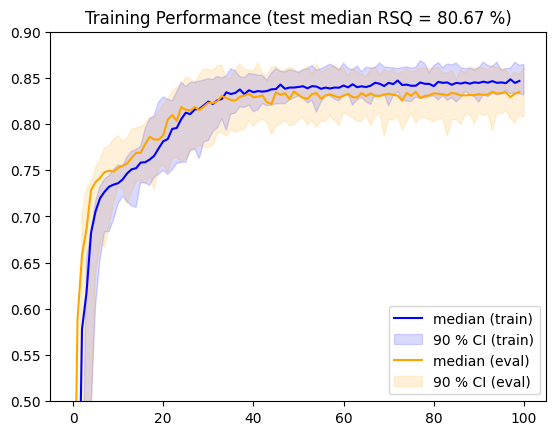

<Figure size 640x480 with 0 Axes>

In [24]:

y1 = np.array([hist.history["r2_score"] for hist in hists])
y2 = np.array([hist.history["val_r2_score"] for hist in hists])

plt.plot(np.quantile(y1,.5, axis = 0), label = 'median (train)', color = 'blue')
plt.fill_between(range(1, n_epochs +1), np.quantile(y1,.05, axis = 0), np.quantile(y1,.95, axis = 0),color = 'blue', alpha = 0.15, label = '90 % CI (train)')
plt.plot(np.quantile(y2,.5, axis = 0), label = 'median (eval)', color = 'orange')
plt.fill_between(range(1, n_epochs +1), np.quantile(y2,.05, axis = 0), np.quantile(y2,.95, axis = 0),color = 'orange', alpha = 0.15, label = '90 % CI (eval)')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'blue', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'orange', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)

plt.title('Training Performance (test median RSQ = ' + str(round(perfs[['RSQ_pct']].median()[0], 2))+ " %)")

plt.legend()
plt.ylim([0.5, 0.9])
plt.show()
plt.savefig(experiment_path + 'results/training_performance.png')

In [25]:
# All plots (if needed)
if False:
  i = 0
  for rep, fold in product(range(nreps), range(nfolds)):
    plot_perf(hists[i], 'r2_score')
    #plt.suptitle('Training Performance (test r2_score = ' + str(round(perfs[ind][2] * 100, 2))+ " %)")
    #'Training Performance (test r2_score = ' + str(round(perfs[ind][2] * 100, 2))+ " %)")
    plt.suptitle('Training Performance for rep = ' + str(rep) + ', fold = ' + str(fold))
    plt.title(' (test RSQ = ' + str(round(perfs.loc[i,'RSQ_pct'], 2))+ " %)")
    plt.ylim([0.5, 0.9])
    plt.show()
    i += 1

### Centralized (5 Features)

In [26]:
experiment_name = '01_central5'

experiment_path = log_path + "/" + experiment_name + "/"
if not os.path.exists(experiment_path + 'logs'): os.makedirs(experiment_path + 'logs')
if not os.path.exists(experiment_path + 'models'): os.makedirs(experiment_path + 'models')
if not os.path.exists(experiment_path + 'results'): os.makedirs(experiment_path + 'results')

In [58]:
%%time

n_epochs = 100

hists = []
for rep, fold in product(range(nreps), range(nfolds)):
    
    id = "r" + str(rep) + "f" + str(fold)
    print('======= rep %s - fold %s  =======' % (rep, fold))
    
    model          = build_model(nfeatures = 5)
    X_train, y_train = select_split(df, features = features[:5], type = 'test', rep = rep, fold = fold)

    
    hist = train_model(
        model, X_train, y_train, 
        epochs = n_epochs, output_msr = "r2_score",
        callbacks = [CSVLogger(experiment_path + "logs/" + id + '_log.csv'  , separator =";")]
        )
    model.save_weights(experiment_path + "models/" + id + '_weights.h5')
    
    hists.append(hist)

======= rep 0 - fold 0  =======
R^2  = 0.7583,  time = 17.7 sec
======= rep 0 - fold 1  =======
R^2  = 0.7267,  time = 17.9 sec
======= rep 0 - fold 2  =======
R^2  = 0.7814,  time = 17.8 sec
======= rep 0 - fold 3  =======
R^2  = 0.8135,  time = 17.3 sec
======= rep 0 - fold 4  =======
R^2  = 0.7186,  time = 17.0 sec
======= rep 1 - fold 0  =======
R^2  = 0.8321,  time = 16.4 sec
======= rep 1 - fold 1  =======
R^2  = 0.7909,  time = 16.7 sec
======= rep 1 - fold 2  =======
R^2  = 0.6818,  time = 16.2 sec
======= rep 1 - fold 3  =======
R^2  = 0.7947,  time = 16.3 sec
======= rep 1 - fold 4  =======
R^2  = 0.8394,  time = 16.8 sec
======= rep 2 - fold 0  =======
R^2  = 0.7990,  time = 16.0 sec
======= rep 2 - fold 1  =======
R^2  = 0.7440,  time = 15.9 sec
======= rep 2 - fold 2  =======
R^2  = 0.7894,  time = 15.5 sec
======= rep 2 - fold 3  =======
R^2  = 0.7523,  time = 14.4 sec
======= rep 2 - fold 4  =======
R^2  = 0.7644,  time = 14.1 sec
======= rep 3 - fold 0  =======
R^2  = 0

In [59]:
# calculate the performance
perfs = [None] * nreps * nfolds

i = 0
for rep, fold in product(range(nreps), range(nfolds)):
  
  model          = hists[i].model
  X_test, y_test = select_split(df, features = features[:5], type = 'test', rep = rep, fold = fold)
  perfs[i]       = [rep, fold] + test_model(model, X_test, y_test)

  i += 1

# convert to DataFrame
perfs = pd.DataFrame(perfs, columns = ["rep", "fold","MAE", 'MSE', 'RSQ']).assign(
    RMSE   = lambda x: np.sqrt(x.MSE),
    RSQ_pct = lambda x: x.RSQ * 100
)

res = perfs[['MAE', 'RMSE', 'RSQ_pct']].describe()[1:].round(2)
res.to_csv(experiment_path + "results/test_performance_overview.csv", sep = ";")
res 

,MAE,RMSE,RSQ_pct
mean,3799.77,5687.09,74.21
std,394.00,481.36,5.31
min,2831.14,4584.92,64.77
25%,3599.07,5482.38,70.79
50%,3826.77,5754.18,73.54
75%,4003.93,5873.66,76.64
max,4603.45,6842.29,85.01


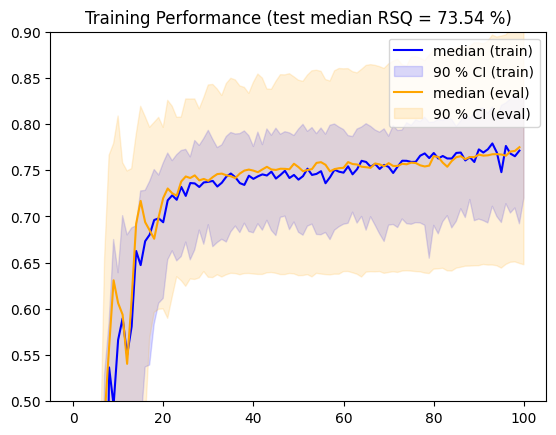

<Figure size 640x480 with 0 Axes>

In [60]:
y1 = np.array([hist.history["r2_score"] for hist in hists])
y2 = np.array([hist.history["val_r2_score"] for hist in hists])

plt.plot(np.quantile(y1,.5, axis = 0), label = 'median (train)', color = 'blue')
plt.fill_between(range(1, n_epochs +1), np.quantile(y1,.05, axis = 0), np.quantile(y1,.95, axis = 0),color = 'blue', alpha = 0.15, label = '90 % CI (train)')
plt.plot(np.quantile(y2,.5, axis = 0), label = 'median (eval)', color = 'orange')
plt.fill_between(range(1, n_epochs +1), np.quantile(y2,.05, axis = 0), np.quantile(y2,.95, axis = 0),color = 'orange', alpha = 0.15, label = '90 % CI (eval)')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'blue', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.0, axis = 0), np.quantile(y,1., axis = 0), color = 'orange', alpha = 0.15, label = '100-90-70 % CI')
#plt.fill_between(range(1, n_epochs +1), np.quantile(y,.05 + .1, axis = 0), np.quantile(y,.95 - .1, axis = 0),color = 'blue', alpha = 0.15)

plt.title('Training Performance (test median RSQ = ' + str(round(perfs[['RSQ_pct']].median()[0], 2))+ " %)")

plt.legend()
plt.ylim([0.5, 0.9])
plt.show()
plt.savefig(experiment_path + 'results/training_performance.png')

### Centralized Tuning
---

Is the centralized model improvable?

- train_model(..., steps_per_epoch = 3) -> improves the result?
- FIXME: What about random forests?
- FIXME: Systematic tuning

### Federated Learning
---

#### Convert Data

In [15]:
df.head()

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,...,rep3-fold0,rep3-fold1,rep3-fold2,rep3-fold3,rep3-fold4,rep4-fold0,rep4-fold1,rep4-fold2,rep4-fold3,rep4-fold4
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,...,train,train,train,train,test,train,train,train,test,train
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.55230,0.0,0.0,1.0,...,train,train,train,train,test,train,train,test,train,train
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.46200,0.0,0.0,1.0,...,train,train,train,test,train,test,train,train,train,train
3,0.326087,1.0,0.181464,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,...,train,test,train,train,train,train,train,train,test,train
4,0.304348,1.0,0.347592,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,...,train,train,test,train,train,train,test,train,train,train


In [21]:
test_size_per_region = 20

NUM_CLIENTS = 4
NUM_EPOCHS = 50
BATCH_SIZE = 128
SHUFFLE_BUFFER = 20
PREFETCH_BUFFER = 5
NUM_ROUNDS = 5
RUN_NAME = f'0,8-3({NUM_ROUNDS})-{NUM_EPOCHS}-epochs-{BATCH_SIZE}-batch-WithRegion/'

In [17]:
# region, rep, fold -> tf dataset per region
clients = df.region.unique()

#def conv2tfdata(X, y): 
#     pass

rep  = 0
fold = 0
client = clients[0]

def get_data_for_region(df, client = clients[0], rep = 0, fold = 0):

    X = df[df.region == client]

    X_train, y_train = select_split(X, features = features[:5], type = 'train', rep = rep, fold = fold)
    X_test, y_test = select_split(X, features = features[:5], type = 'test', rep = rep, fold = fold)
    
    train_fed = tf.data.Dataset.from_tensor_slices((
        tf.convert_to_tensor(X_train),
        tf.convert_to_tensor(y_train)
    )).repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER)

    test_fed = (X_test, y_test)
    # -> auch konvertieren?

    return (train_fed, test_fed)

get_data_for_region(df)

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 (           age  sex       bmi  children  smoker
  18    0.826087  1.0  0.654829       0.0     0.0
  84    0.413043  0.0  0.506860       0.4     1.0
  87    0.826087  0.0  0.302394       0.0     0.0
  99    0.434783  1.0  0.089857       0.0     1.0
  120   0.565217  1.0  0.568738       0.4     0.0
  ...        ...  ...       ...       ...     ...
  1231  0.043478  0.0  0.157116       0.0     1.0
  1252  0.043478  1.0  0.305085       0.0     1.0
  1253  0.478261  0.0  0.358892       0.8     0.0
  1263  0.543478  0.0  0.375034       0.2     0.0
  1313  0.021739  0.0  0.504170       0.4     1.0
  
  [65 rows x 5 columns],
  18      10602.38500
  84      39836.51900
  87      11073.17600
  99      15820.69900
  120      7740.33700
             ...     
  1231    20167.33603
  1252    16232.84700
  1253    15828.82173
  1263     7337.74800
  1

In [19]:
dats_fed = [get_data_for_region(df, client = client, rep = 0, fold = 0) for client in clients]

dats_fed[0]

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 (           age  sex       bmi  children  smoker
  18    0.826087  1.0  0.654829       0.0     0.0
  84    0.413043  0.0  0.506860       0.4     1.0
  87    0.826087  0.0  0.302394       0.0     0.0
  99    0.434783  1.0  0.089857       0.0     1.0
  120   0.565217  1.0  0.568738       0.4     0.0
  ...        ...  ...       ...       ...     ...
  1231  0.043478  0.0  0.157116       0.0     1.0
  1252  0.043478  1.0  0.305085       0.0     1.0
  1253  0.478261  0.0  0.358892       0.8     0.0
  1263  0.543478  0.0  0.375034       0.2     0.0
  1313  0.021739  0.0  0.504170       0.4     1.0
  
  [65 rows x 5 columns],
  18      10602.38500
  84      39836.51900
  87      11073.17600
  99      15820.69900
  120      7740.33700
             ...     
  1231    20167.33603
  1252    16232.84700
  1253    15828.82173
  1263     7337.74800
  1

#### Model

In [50]:
def model_fed():
    def model_fn():
        model = build_model(nfeatures = 5, compile = False)
        return tff.learning.models.from_keras_model(
            model,
            input_spec = dats_fed[0][0].element_spec,
            loss = tf.keras.losses.MeanAbsoluteError(),
            #loss = tf.keras.losses.MeanSquaredError(),
            metrics = [tf.keras.metrics.MeanAbsoluteError()
            #metrics = [tf.keras.losses.MeanSquaredError()
            #, tfa.metrics.RSquare()
            ]
        )
    #return model_fn()


    iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        client_optimizer_fn=lambda: tf.optimizers.Adam(learning_rate = .05),
        server_optimizer_fn=lambda: tf.optimizers.Adam(learning_rate = .05),)
    return iterative_process
#print(iterative_process.initialize.type_signature.formatted_representation())

In [51]:
model = model_fed()

In [52]:
print(model.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[5,40],
      float32[40],
      float32[40,40],
      float32[40],
      float32[40,20],
      float32[20],
      float32[20,1],
      float32[1]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[5,40],
    float32[5,40],
    float32[40],
    float32[40],
    float32[40,40],
    float32[40,40],
    float32[40],
    float32[40],
    float32[40,20],
    float32[40,20],
    float32[20],
    float32[20],
    float32[20,1],
    float32[20,1],
    float32[1],
    float32[1]
  >
>@SERVER)


#### Training

In [57]:
def train_model_fed(model, dats_fed, epochs = 5):
    state = model.initialize()
    hist = []
    states = []

    for round_num in range(1, epochs):
        result = model.next(state, [f[0] for f in dats_fed])
        state = result.state
        metrics = dict(result.metrics['client_work']['train'].items())

        # used for tensorboard
        #for name, value in metrics['client_work']['train'].items():
        #    tf.summary.scalar(name, value, step=round_num)
        states.append(state)
        hist.append(metrics)

        print('round  {:2d}, metrics={}'.format(round_num, metrics))

    return hist, state


In [58]:
dats_fed = [get_data_for_region(df, client = client, rep = 0, fold = 1) for client in clients]
model = model_fed()
train_model_fed(model, dats_fed)

2023-05-05 09:22:06.868223: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-05 09:22:06.868475: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-05 09:22:06.945893: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-05 09:22:06.946555: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-05 09:22:08.006408: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-05 09:22:08.006709: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-05 09:22:08.420670: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-05 09:22:08.420897: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


round   1, metrics={'mean_absolute_error': 5578.6895, 'loss': 5588.756, 'num_examples': 53500, 'num_batches': 420}
round   2, metrics={'mean_absolute_error': 5257.211, 'loss': 5265.8286, 'num_examples': 53500, 'num_batches': 420}
round   3, metrics={'mean_absolute_error': 5087.199, 'loss': 5095.0615, 'num_examples': 53500, 'num_batches': 420}
round   4, metrics={'mean_absolute_error': 4952.6553, 'loss': 4959.6147, 'num_examples': 53500, 'num_batches': 420}


([{'mean_absolute_error': 5578.6895,
   'loss': 5588.756,
   'num_examples': 53500,
   'num_batches': 420},
  {'mean_absolute_error': 5257.211,
   'loss': 5265.8286,
   'num_examples': 53500,
   'num_batches': 420},
  {'mean_absolute_error': 5087.199,
   'loss': 5095.0615,
   'num_examples': 53500,
   'num_batches': 420},
  {'mean_absolute_error': 4952.6553,
   'loss': 4959.6147,
   'num_examples': 53500,
   'num_batches': 420}],
 LearningAlgorithmState(global_model_weights=ModelWeights(trainable=[array([[-7.42664337e-02,  1.65962145e-01,  3.61660868e-01,
          4.44427639e-01,  2.87957579e-01,  1.00085482e-01,
          1.61963254e-01, -1.13282502e-02,  5.28207242e-01,
          3.72924596e-01,  5.00314951e-01, -8.75784382e-02,
         -3.12175959e-01,  2.33384266e-01,  3.84789944e-01,
          4.76620197e-01, -1.97369326e-02,  3.65358591e-01,
          2.03962520e-01, -2.64486298e-03,  2.84855723e-01,
          4.32961583e-01,  2.03381658e-01,  3.01712424e-01,
          3.058671

In [53]:
dats_fed = [get_data_for_region(df, client = client, rep = 0, fold = 1) for client in clients]

state = model.initialize()
hist = []

for round_num in range(1, NUM_ROUNDS):
    result = model.next(state, [f[0] for f in dats_fed])
    state = result.state
    metrics = dict(result.metrics['client_work']['train'].items())

    # used for tensorboard
    #for name, value in metrics['client_work']['train'].items():
    #    tf.summary.scalar(name, value, step=round_num)
    hist.append(metrics)

    print('round  {:2d}, metrics={}'.format(round_num, metrics))


# Create the test data for model evaluation
X_test = pd.concat([f[1][0] for f in dats_fed])
y_test = pd.concat([f[1][1] for f in dats_fed])

test_sets = [tf.data.Dataset.from_tensor_slices(
    (tf.convert_to_tensor(np.expand_dims(el[1][0], axis=0)), 
    tf.convert_to_tensor(np.expand_dims(el[1][1], axis=0)))) 
    for el in dats_fed]

# Model evaluation
evaluation = tff.learning.build_federated_evaluation(model_fed)
# print(evaluation.type_signature.formatted_representation())
model_weights = iterative_process.get_model_weights(state)
test_metrics = evaluation(model_weights, test_sets)
test_metrics

2023-05-05 09:18:34.089772: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-05 09:18:34.090077: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-05 09:18:34.174887: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-05 09:18:34.175271: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-05 09:18:35.356637: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-05 09:18:35.356958: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-05 09:18:35.862456: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-05 09:18:35.862667: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


round   1, metrics={'mean_absolute_error': 5505.506, 'loss': 5515.258, 'num_examples': 53500, 'num_batches': 420}
round   2, metrics={'mean_absolute_error': 5166.5703, 'loss': 5174.634, 'num_examples': 53500, 'num_batches': 420}
round   3, metrics={'mean_absolute_error': 5024.069, 'loss': 5031.4326, 'num_examples': 53500, 'num_batches': 420}
round   4, metrics={'mean_absolute_error': 4888.4067, 'loss': 4895.1074, 'num_examples': 53500, 'num_batches': 420}


/tmp/ipykernel_4715/76683131.py:29: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  evaluation = tff.learning.build_federated_evaluation(model_fed)


TypeError: Expected tensorflow_federated.python.learning.models.variable.VariableModel, found tensorflow_federated.python.learning.templates.learning_process.LearningProcess.

In [44]:
#iterative_process hist?
# -> hist, or e.g.
[x['loss'] for x in hist]

[6000.822, 5579.4297, 5348.0576, 5165.1562]

##### Stepwise

In [65]:
state = iterative_process.initialize()

2023-05-04 17:09:46.467290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 17:09:46.467545: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-04 17:09:46.468667: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-04 17:09:46.470680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 17:09:46.470925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 17:09:46.470999: I tensor

In [68]:
for round_num in tqdm.tqdm(range(1, NUM_ROUNDS)):
    result = iterative_process.next(state, [f[0] for f in dats_fed])
    state = result.state
    metrics = result.metrics
    for name, value in metrics['client_work']['train'].items():
        tf.summary.scalar(name, value, step=round_num)




  0%|          | 0/49 [00:00<?, ?it/s]2023-05-04 17:10:27.645746: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 17:10:27.645826: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-04 17:10:27.646002: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-04 17:10:27.646438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 17:10:27.646502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support

In [76]:
result.state

LearningAlgorithmState(global_model_weights=ModelWeights(trainable=[array([[ 1.22289264e+00,  2.01259375e-01,  1.62984252e+00,
        -5.16965628e-01,  1.92979276e-01,  1.34123564e+00,
         1.01628768e+00,  1.21631289e+00, -9.28788856e-02,
         1.52408171e+00,  1.51187241e+00,  1.59950483e+00,
         1.12898040e+00,  1.32767522e+00, -2.04000026e-01,
         1.60179615e+00,  1.57513309e+00,  1.24625623e+00,
         1.29830873e+00, -3.76958549e-01, -2.75775582e-01,
         1.47463322e+00,  7.96053827e-01,  1.41387641e+00,
         1.72632313e+00,  5.41266322e-01, -2.62217194e-01,
         1.53241134e+00,  1.62560010e+00, -5.58543861e-01,
        -5.60697317e-01,  1.04053509e+00,  1.42987454e+00,
         1.49762988e+00,  4.71613705e-01,  1.15712261e+00,
         1.02971900e+00,  1.24557960e+00,  1.43491614e+00,
         3.60741079e-01],
       [-9.81879085e-02,  1.25783324e-01, -1.63121849e-01,
        -1.16910629e-01,  1.11124948e-01,  1.65915921e-01,
        -7.30977654e-

In [78]:
# Create the test data for model evaluation
X_test = pd.concat([f[1][0] for f in dats_fed])
y_test = pd.concat([f[1][1] for f in dats_fed])

test_sets = [tf.data.Dataset.from_tensor_slices(
    (tf.convert_to_tensor(np.expand_dims(el[1][0], axis=0)), 
    tf.convert_to_tensor(np.expand_dims(el[1][1], axis=0)))) 
    for el in dats_fed]

In [80]:
# Model evaluation
evaluation = tff.learning.build_federated_evaluation(model_fed)
# print(evaluation.type_signature.formatted_representation())
model_weights = iterative_process.get_model_weights(state)
train_metrics = evaluation(model_weights, test_sets)
train_metrics

/tmp/ipykernel_15173/577834906.py:2: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  evaluation = tff.learning.build_federated_evaluation(model_fed)
2023-05-04 17:14:22.991804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 17:14:22.991861: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-04 17:14:22.992026: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-04 17:14:22.992387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 17:14:22.992454: I tensorflow

OrderedDict([('eval',
              OrderedDict([('mean_absolute_error', 2885.5942),
                           ('loss', 2897.638),
                           ('num_examples', 268),
                           ('num_batches', 4)]))])

In [ ]:
# -> 2897.638

#### Previous Work

In [49]:
df.head()

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,...,rep3-fold0,rep3-fold1,rep3-fold2,rep3-fold3,rep3-fold4,rep4-fold0,rep4-fold1,rep4-fold2,rep4-fold3,rep4-fold4
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,...,train,train,train,train,test,train,train,train,test,train
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.55230,0.0,0.0,1.0,...,train,train,train,train,test,train,train,test,train,train
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.46200,0.0,0.0,1.0,...,train,train,train,test,train,test,train,train,train,train
3,0.326087,1.0,0.181464,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,...,train,test,train,train,train,train,train,train,test,train
4,0.304348,1.0,0.347592,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,...,train,train,test,train,train,train,test,train,train,train


In [50]:
# Create test and train sets and put them into random_client_ds, use four clients which are independent of the region
def get_dataset_random_region(dataset, num_clients=4, test_size_per_region=20):
    """Creates a list with client datasets independent of the region.

    :param dataset: The dataset to get the regional data from
    :type dataset: pandas.DataFrame
    :param num_clients: the number of clients create (equal big datasets per client), default value is 4 clients
    :type num_clients: int, optional
    :param test_size_per_region: The amount of values to separate for testing, default are 20
    :type test_size_per_region: int, optional
    :return: List of the prepared dataset with one entry per region, the test values and labels for each region
    :rtype: List of (tensorflow.python.data.ops.dataset_ops.PrefetchDataset, tuple of pandas.core.series.Series)"""
    size_of_client_ds = int(dataset.shape[0] / num_clients)

    dataset_to_split = dataset.copy()
    dataset_to_split.pop("region")
    random_client_ds = []
    for i in range(num_clients):
        sampled = dataset_to_split.sample(n=size_of_client_ds)
        dataset_to_split.drop(sampled.index)

        X_test = sampled.head(test_size_per_region)
        y_test = X_test.pop('charges')

        X_train = sampled.tail(size_of_client_ds - test_size_per_region)
        y_train = X_train.pop('charges')

        fed_train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_train), tf.convert_to_tensor(y_train)))

        train_set = fed_train_dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER)
        test_set = (X_test, y_test)

        random_client_ds.append((train_set, test_set))

    return random_client_ds

# errors
#random_client_ds = get_dataset_random_region(df, num_clients=NUM_CLIENTS, test_size_per_region=test_size_per_region)

In [ ]:
# -> tensored splits
# use e.g. https://www.appsloveworld.com/tensorflow/9/how-to-create-federated-dataset-from-a-csv-file

In [51]:
build_model(compile = False).summary()

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_332 (Dense)           (None, 40)                400       
                                                                 
 dense_333 (Dense)           (None, 40)                1640      
                                                                 
 dense_334 (Dense)           (None, 20)                820       
                                                                 
 dense_335 (Dense)           (None, 1)                 21        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [52]:
build_model(nfeatures = 5)

In [53]:

# A helper function for federated learning
def model_fn(input_features = 9):

  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = build_model(
          features = input_features
  )
  return tff.learning.models.from_keras_model(
      keras_model,
      # without region: 
      #input_spec = federated_insurance_data[0][0].element_spec,
      input_spec = random_client_ds[0][0].element_spec,
      loss = tf.keras.losses.MeanAbsoluteError(),
      #loss = tf.keras.losses.MeanSquaredError(),
      metrics = [tf.keras.metrics.MeanAbsoluteError()
      #metrics = [tf.keras.losses.MeanSquaredError()
      #,tfa.metrics.RSquare()
      ]
  )

# Helper functions for different features as input
def model_fn_5():
    return model_fn(5)

def model_fn_5_mod():
  return model_fn(5, initializer = 'glorot_uniform', activation = 'relu')

def model_fn_9():
  return model_fn(9)

def model_fn_9_mod():
  return model_fn(9, initializer = 'glorot_uniform', activation = 'relu')

In [54]:
# Inputs
# model_fn_9
# random_client_ds

# Create iterative learning process which will perform the federated learning
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn_9,
    client_optimizer_fn=lambda: tf.optimizers.Adam(learning_rate = .05),
    server_optimizer_fn=lambda: tf.optimizers.Adam(learning_rate = .05),)

state = iterative_process.initialize()

# Train the federated model with random clients
for round_num in tqdm.tqdm(range(1, NUM_ROUNDS)):
    result = iterative_process.next(state, [f[0] for f in random_client_ds])
    state = result.state
    metrics = result.metrics
    for name, value in metrics['client_work']['train'].items():
        tf.summary.scalar(name, value, step=round_num)

TypeError: build_model() got an unexpected keyword argument 'features'